<div style="font-size:28pt; line-height:30pt; font-weight:bold; text-align:center;">Large Margin Deep Networks for Classification </div>

The large margin principle has produced remarkable theoretical and empirical results for classification (SVM - Vapnik, 1995) and regression problems (SVR - Drucker et al., 1997).

Desirable benefits of large margin classifiers include : 
- better generalization properties
- robustness to input perturbations.
  
However, exact large margin algorithms are only suitable for **shallow models** where the margin has an analytical form (the l2 norm of the parameters). To overcome the limitations of classical margin approaches, G.F. Elsayed et al. designed a novel **loss function based on a first-order approximation of the margin**. 

This loss function is applicable to any network architecture (e.g., arbitrary depth, activation function, use of convolutions, residual networks), and complements existing general-purpose regularization techniques such as weight-decay, dropout and batch normalization.

# **I. Theoretical definition**

## 1. Large margin principle
*The following definitions have already been explored in the SVM course in AML.*

Consider a classification problem with n classes.  
Suppose we use a function $f_i: X → R$, for $i = 1,. . ., n$ that generates a prediction score for classifying the input vector $x \in X$ to class $i$. The predicted label is decided by the class with maximal score, i.e. $i^∗ = \operatorname{argmax}_i f_i(x)$.

Define the decision boundary for each class pair {i, j} as:
$$D_{i,j} = \{x | f_i(x) = f_j (x)\} \;\;\;\;(1) $$  

Under this definition, the distance of a point x to the decision boundary $D_{i,j}$ is defined as the smallest distance to be moved so that x
reaches the decision boundary, implying a score tie. Hence,
$$d_{f,x,\{i,j\}} = \min_δ \|δ\|_p \; \; s.t. \; \; f_i(x + δ) = f_j (x + δ) \;\;\;\;(2) $$

## 2. Large Margin Deep Networks

Using the above distance, we can develop a large margin loss:

We start with a training set consisting of pairs $(x_k, y_k)$. We penalize the displacement of each $x_k$ to satisfy the margin constraint for separating class $y_k$ from class i ($i \ne y_k$). This implies using the following loss function:
$$ \max\{0, γ + d_{f,x_k,\{i,y_k\}} sign (f_i(x_k) − f_{yk}(x_k))\} \;\;\;\;(3) $$
 
In a multiclass setting, we aggregate individual losses arising from each $i \ne y_k$ by some aggregation operator *A* ($max$ or $\sum$):

$$A_{i \ne y_k} \max\{0, γ + d_{f,x_k,\{i,y_k\}} sign (f_i(x_k) − f_{yk}(x_k))\}  \;\;\;\;(4) $$

In order to learn $f_i$, we assume it is parameterized by a vector w and should use the notation $f_i(x; w)$; for brevity we keep using the notation $f_i(x)$. The goal is to minimize the loss w.r.t. w:
$$w^∗  = \operatorname{argmin}_w \sum_k A_{i \ne y_k} \max\{0, γ + d_{f,x_k,\{i,y_k\}} sign (f_i(x_k) − f_{yk}(x_k))\} \;\;\;\;(5) $$

The above formulation depends on d, whose exact computation from (2) is intractable when $f_i$’s are nonlinear (remember we are dealing with neural networks!). Instead, we present an **approximation to d**:
$$ \tilde{d}_{f,x,\{i,j\}} = \frac{|f_i(x) − f_j (x)|}{\| ∇_xf_i(x) - ∇_xf_j(x) \|_q} \;\;(6)$$
where $\|\|_q$ is the dual-norm of $\|\|_p$. Using the linear approximation, the loss function becomes after simplification:
$$ \hat{w} =  \operatorname{argmin}_w \sum_k A_{i \ne y_k} \max \left\{0, γ + \frac{f_i(x_k) − f_{y_k} (x_k)}{\| ∇_xf_i(x_k) - ∇_xf_{y_k}(x_k) \|_q} \right\} \;\; (7)$$

*NB.* (6) coincides with an SVM for the special case of a linear classifier.

## 3. Margin for Hidden Layers
The classic notion of margin is defined based on the distance of input samples from the decision boundary using input/output association. In deep networks, however, the output is shaped from input by going through a number of transformations (layers). Thus, **we can define the margin based on any intermediate representation and the ultimate decision boundary**.

The input x in the margin formulation (7) is replaced with the intermediate representation of x. More precisely, let $h_l$ denote the output of the l’th layer ($h_0 = x$) and $γ_l$ be the margin enforced for its corresponding representation. Then the margin loss (7) can be adapted as following :
$$ \hat{w} =  \operatorname{argmin}_w \sum_{l,k} A_{i \ne y_k} \max \left\{0, γ_l + \frac{f_i(x_k) − f_{y_k} (x_k)}{\| ∇_{h_l}f_i(x_k) - ∇_{h_l}f_{y_k}(x_k) \|_q} \right\} \;\; (8)$$

# **II. Experiments**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam

from LargeMarginLoss import LargeMarginLoss
from test import test
from train import train_ce, train_lm
from network import LinearNet
from utils import create_loaders

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt


## 1. Data loading
We use the MNIST dataset.

Training examples are of shape (800, 2)
Testing examples are of shape (200, 2)


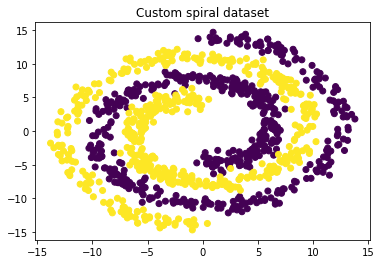

In [2]:
Dataset_size = 500 #FEW SAMPLES
x,y = make_swiss_roll(n_samples=Dataset_size, random_state=0)

Base_dataset = x[:,[0,2]] + np.random.randn(Dataset_size,2)/1.5

X_spiral = np.concatenate((Base_dataset,-Base_dataset))
y_spiral = [0]*Dataset_size + [1]*Dataset_size

plt.scatter(
    x=X_spiral[:,0],
    y=X_spiral[:,1],c=y_spiral)
plt.title('Custom spiral dataset')

#split train-test
X_train, X_test, y_train, y_test = train_test_split(X_spiral, y_spiral, test_size=0.2, random_state=0)

print('Training examples are of shape',X_train.shape)
print('Testing examples are of shape',X_test.shape)

train_loader, test_loader = create_loaders(X_train,X_test,y_train,y_test)

n_classes = 2

## 2. Network training with the Large Margin loss.

In [7]:
lm = LargeMarginLoss(
    gamma=5,
    top_k=n_classes,
    dist_norm=np.inf
)

device = torch.device("cpu")

net_lm = LinearNet(2,n_classes).to(device)
optim = Adam(net_lm.parameters())
for i in range(0, 30):
    train_lm(net_lm, train_loader, n_classes, optim, i, lm, device)
    test(net_lm, test_loader, device)

Train Epoch: 0 [0/800 (0%)]	Loss: 3.567280
Train Epoch: 0 [400/800 (50%)]	Loss: 3.711987
Test set: Accuracy: 140/200 (70%)

Train Epoch: 1 [0/800 (0%)]	Loss: 5.188588
Train Epoch: 1 [400/800 (50%)]	Loss: 4.083294
Test set: Accuracy: 141/200 (70%)

Train Epoch: 2 [0/800 (0%)]	Loss: 5.319712
Train Epoch: 2 [400/800 (50%)]	Loss: 4.283368
Test set: Accuracy: 143/200 (72%)

Train Epoch: 3 [0/800 (0%)]	Loss: 5.236843
Train Epoch: 3 [400/800 (50%)]	Loss: 4.214478
Test set: Accuracy: 144/200 (72%)

Train Epoch: 4 [0/800 (0%)]	Loss: 5.193384
Train Epoch: 4 [400/800 (50%)]	Loss: 4.139444
Test set: Accuracy: 144/200 (72%)

Train Epoch: 5 [0/800 (0%)]	Loss: 5.158015
Train Epoch: 5 [400/800 (50%)]	Loss: 4.172232
Test set: Accuracy: 144/200 (72%)

Train Epoch: 6 [0/800 (0%)]	Loss: 5.085520
Train Epoch: 6 [400/800 (50%)]	Loss: 4.201066
Test set: Accuracy: 144/200 (72%)

Train Epoch: 7 [0/800 (0%)]	Loss: 5.098969
Train Epoch: 7 [400/800 (50%)]	Loss: 4.211873
Test set: Accuracy: 144/200 (72%)

Train Ep

## 3. Network training with the Cross Entropy loss.
Comparing with Cross Entropy.

In [8]:
net_ce = LinearNet(2,n_classes).to(device)
optim = Adam(net_ce.parameters())
for i in range(0, 30):    
    train_ce(net_ce, train_loader, optim, i, device)
    test(net_ce, test_loader, device)

Train Epoch: 0 [0/800 (0%)]	Loss: 0.632267
Train Epoch: 0 [400/800 (50%)]	Loss: 0.821018
Test set: Accuracy: 140/200 (70%)

Train Epoch: 1 [0/800 (0%)]	Loss: 0.955027
Train Epoch: 1 [400/800 (50%)]	Loss: 0.799974
Test set: Accuracy: 141/200 (70%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.943284
Train Epoch: 2 [400/800 (50%)]	Loss: 0.798611
Test set: Accuracy: 141/200 (70%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.943442
Train Epoch: 3 [400/800 (50%)]	Loss: 0.805485
Test set: Accuracy: 142/200 (71%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.933183
Train Epoch: 4 [400/800 (50%)]	Loss: 0.812754
Test set: Accuracy: 142/200 (71%)

Train Epoch: 5 [0/800 (0%)]	Loss: 0.935949
Train Epoch: 5 [400/800 (50%)]	Loss: 0.801997
Test set: Accuracy: 142/200 (71%)

Train Epoch: 6 [0/800 (0%)]	Loss: 0.933304
Train Epoch: 6 [400/800 (50%)]	Loss: 0.808679
Test set: Accuracy: 142/200 (71%)

Train Epoch: 7 [0/800 (0%)]	Loss: 0.931941
Train Epoch: 7 [400/800 (50%)]	Loss: 0.798902
Test set: Accuracy: 143/200 (72%)

Train Ep

## 4. Plot decision boudary

In [5]:
def get_y(x,model):
    output, *_ = model(x)
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    return pred

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    Z = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).float()
    Z = get_y(Z,model)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary(X,y,model,ax,title):
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('Sepal length')
    ax.set_xlabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

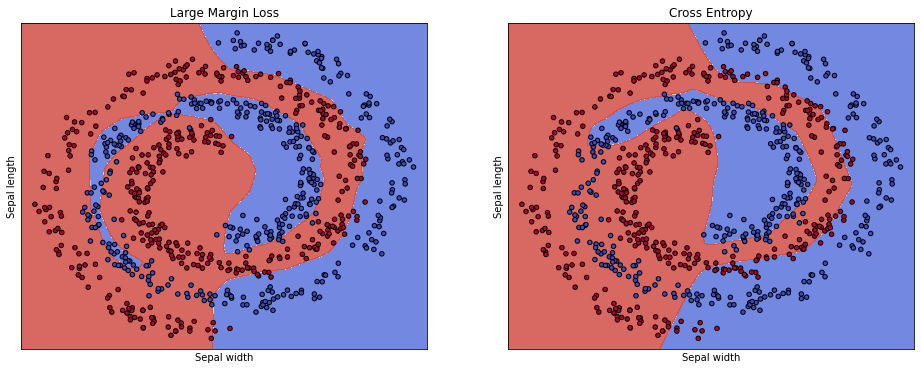

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# title for the plots
titles = ['Large Margin Loss','Cross Entropy']
models = [net_lm,net_ce]
for i in range(2):
    plot_decision_boundary(X_train,y_train,models[i],axs[i],titles[i])
plt.show()

<div class="alert alert-success"><b>Things to keep in mind:</b>

- **Decision Boundary**: Separation point between two different classes. At the decision boundary, there is ambiguity in class decisions.
- **Margin**: The smallest non negative distance between decision boundary and closest class point
- **Support Vector machines**: The most well known maximum margin principle based classification models - use support vectors (points closest to
decision boundary) to estimate margin.
- **Margins in Deep Networks**: Easy to compute in output space, very difficult (sometimes impossible) to compute in input space. The solution is a novel network-agnostic loss function which captures the principle of large margin separation in both the input and hidden layers for deep neural networks.
</div>